In [3]:
import sys
sys.path.insert(0, '..') 
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
relu = torch.nn.ReLU()

from src.modular_rnn import ModRNN, RingModule

/Users/alexnegron/miniconda3/envs/torch/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448801785/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.has_mps else 'cpu'
print(device)

mps


/var/folders/3l/tv69nng54nsdx0t5kvn28ksh0000gn/T/ipykernel_50117/3424976132.py:3: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = 'mps' if torch.has_mps else 'cpu'


# Test bump initialization

- Initialize bumps with an impulse 
- Run dynamics equations until bumps are stable and centered where the impulse was applied

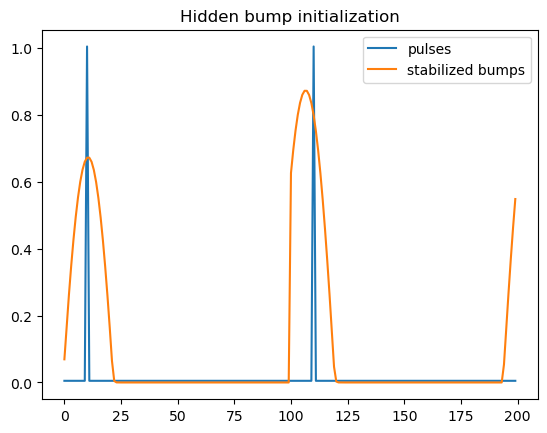

In [70]:
rnn = ModRNN(1,
             2,
             device=device,
             nNeurons=100,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 10
            )
bump_period = int(rnn.CTRNN.nNeurons / rnn.CTRNN.nBumps) # bump distance
pulse_inds = bump_period * np.arange(rnn.CTRNN.nBumps)
pulse_inds = np.concatenate((pulse_inds, rnn.CTRNN.nNeurons + pulse_inds))
pulse_inds += int(rnn.CTRNN.pulsePosition % bump_period)
pulse_inputs = torch.zeros(2 * rnn.CTRNN.nNeurons, device=rnn.CTRNN.device)
pulse_inputs[pulse_inds] = rnn.CTRNN.pulseMag

init_hidden_pre = 0.005 * torch.ones(2 * rnn.CTRNN.nNeurons, device=rnn.CTRNN.device) + pulse_inputs # initial hidden state before dynamics to stabilize bumps
init_hidden_post = rnn.CTRNN.init_hidden() # initial hidden state *after* dynamics to stabilize bumps


plt.plot(init_hidden_pre.cpu().numpy(), label='pulses')
plt.plot(init_hidden_post.detach().numpy(), label='stabilized bumps')
plt.title('Hidden bump initialization')
plt.legend()
plt.show()

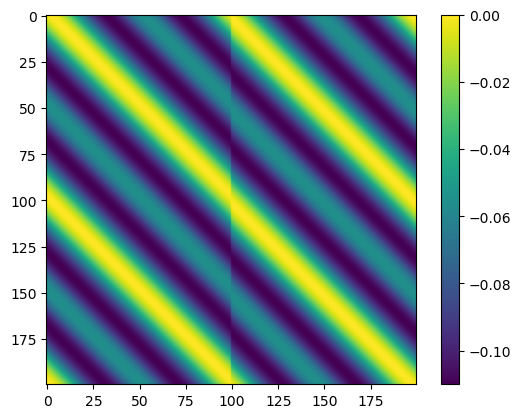

In [71]:
plt.imshow(rnn.CTRNN.wAttractor.numpy())
plt.colorbar()
plt.show()

Some remarks: 
- Every time the network is initialized, the bumps are placed at the same location. I think this only works if the training data trajectories also all start from the same location on the ring, currently $\theta_0 = 0$ rad.

# Test bump dynamics

Do the bumps move in the right direction for different values of $\omega(t)$? They should be moving in opposite directions.

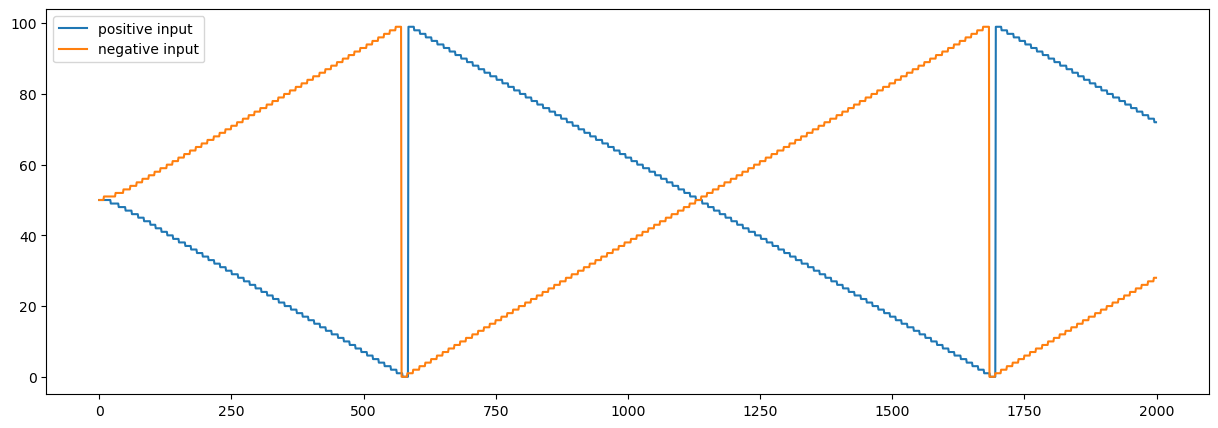

In [26]:
import matplotlib.pyplot as plt

# Initialize the model
input_size = 1  
output_size = 2

model = ModRNN(input_size,
             output_size,
             device=device,
             nNeurons=100,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 50
            )

# Initialize some hidden activity
hidden = model.CTRNN.init_hidden()

# Create a positive and a negative input
positive_input = torch.tensor([0.5]).to(device)
negative_input = torch.tensor([-0.5]).to(device)

# Define the number of steps
num_steps = 2000

# Step the dynamics forward for positive input and track the maximum position
hidden_after_positive = hidden.clone()
max_positions_positive = []
for _ in range(num_steps):
    hidden_after_positive = model.CTRNN.recurrence(positive_input, hidden_after_positive)
    max_positions_positive.append(hidden_after_positive[:model.CTRNN.nNeurons].argmax().item())

# Step the dynamics forward for negative input and track the maximum position
hidden_after_negative = hidden.clone()
max_positions_negative = []
for _ in range(num_steps):
    hidden_after_negative = model.CTRNN.recurrence(negative_input, hidden_after_negative)
    max_positions_negative.append(hidden_after_negative[:model.CTRNN.nNeurons].argmax().item())

# Plot the position of the maximum of the bump in the first ring for both positive and negative inputs
plt.figure(figsize=(15, 5))
plt.plot(max_positions_positive, label='positive input')
plt.plot(max_positions_negative, label='negative input')
plt.legend()
plt.show()

# Integrating a single trajectory

- Input data: $\omega(t)$
- Target data: $\left( \cos \left( \int_0^t \omega(s) \mathrm{d}s \right), \sin \left( \int_0^t \omega(s) \mathrm{d}s \right) \right)$; i.e. the $x,y$ coordinates of the position on the ring at time $t$.

Network is trained with supervised learning to integrate the velocity. The network is trained on a single trajectory, and the loss function is the mean squared error between the network output and the target data.

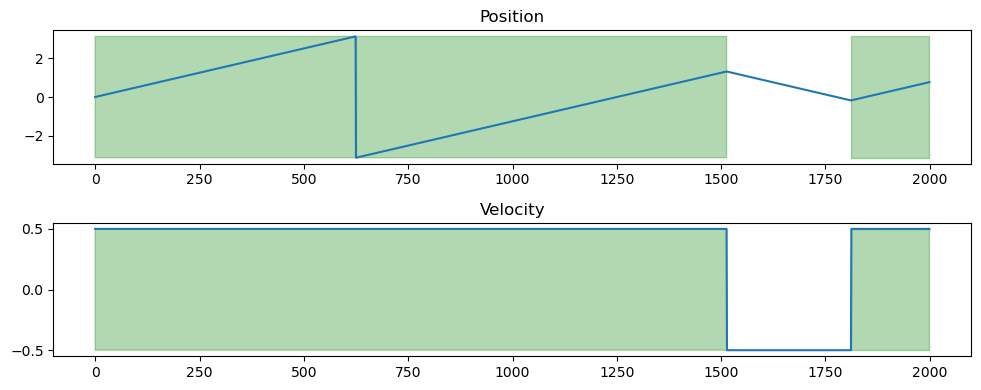

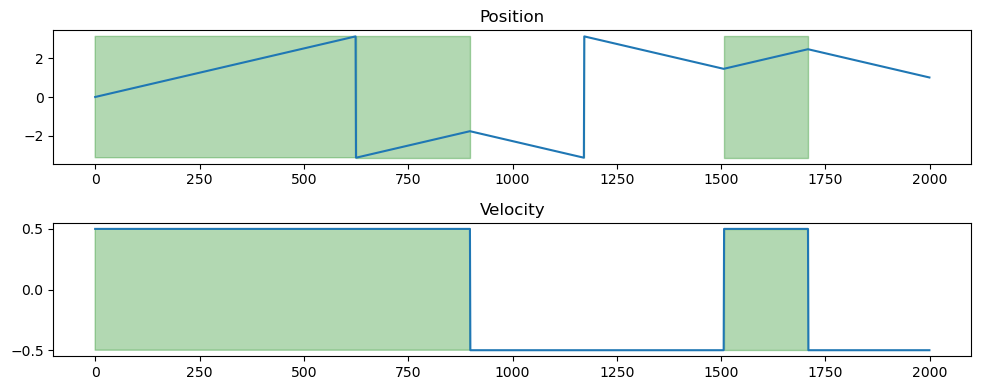

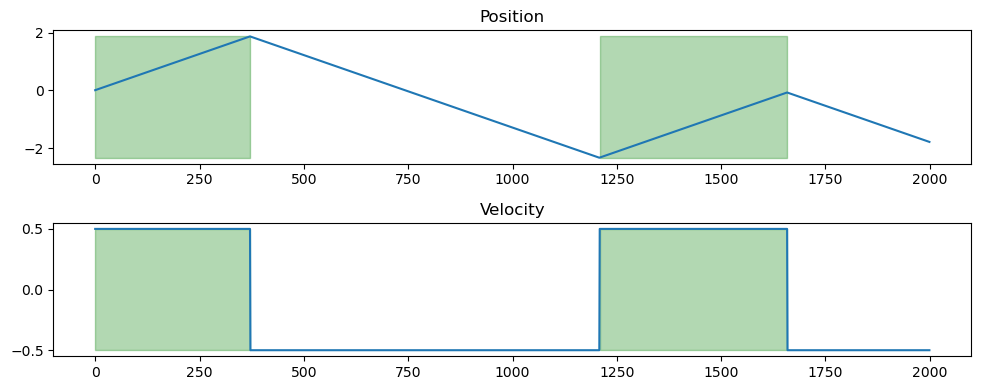

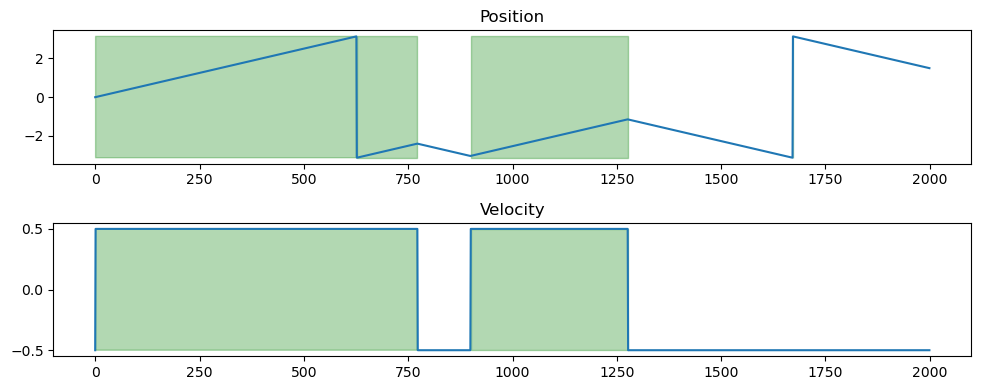

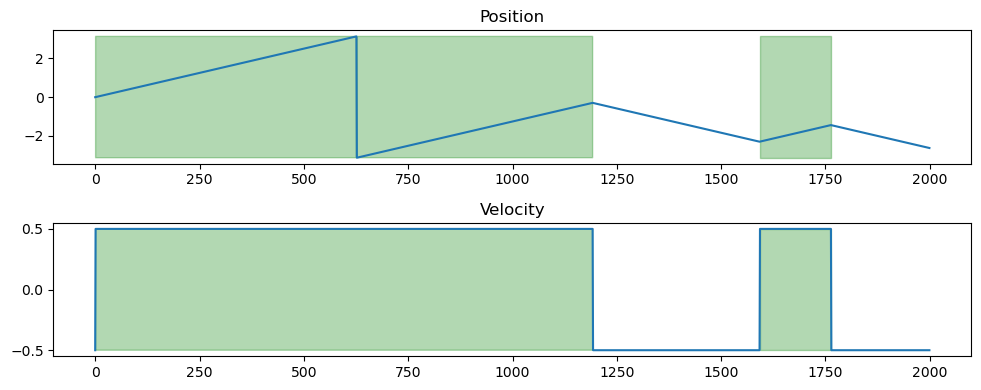

In [7]:
# training data generation
from tasks.independent_integration_task import generate_dataset

num_samples = 5
num_trajectories = 1
num_timesteps = 2000
num_flips = 3
# omega_process = 'constant'
omega_process = 'binary'
omega_value = 0.5
dt = .01

# Generate the dataset
inputs, targets = generate_dataset(num_samples,
                                   num_timesteps,
                                   num_trajectories,
                                   trajectory_type=omega_process,
                                   dt=dt,
                                   num_flips=num_flips,
                                   omega_value=omega_value,
                                   include_initial_position=False
                                   )

# Plot the dataset
traj_idx = 0
for i in range(num_samples)[::]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))

    # Compute the angle from the target positions
    angle = np.arctan2(targets[i, :, 2*traj_idx+1], targets[i, :, 2*traj_idx])

    # Plot corresponding position from targets
    axs[0].plot(angle)
    axs[0].set_title('Position')

    # Shade regions where position is increasing
    axs[0].fill_between(range(len(angle)), angle.min(), angle.max(), where=np.diff(angle, prepend=0) > 0, color='green', alpha=0.3)

    # Plot omega trajectory
    velocity = inputs[i, :, traj_idx]
    axs[1].plot(velocity)
    axs[1].set_title('Velocity')

    # Shade regions where velocity is positive
    axs[1].fill_between(range(len(velocity)), velocity.min(), velocity.max(), where=velocity > 0, color='green', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [35]:
print(inputs.shape)
print(targets.shape)

(5, 2000, 1)
(5, 2000, 2)


In [21]:
# initialize the network 

torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.set_default_tensor_type(torch.FloatTensor)
# device = 'mps' if torch.backends.mps.is_built() else 'cpu'
print(f'device = {device}')

input_size = inputs.shape[2]
output_size = targets.shape[2]
nNeurons=100


net = ModRNN(input_size,
             output_size,
             device=device,
             nNeurons=nNeurons,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 12
            )

criterion = torch.nn.MSELoss()
learning_rate = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 200
clip_value = 2 # Define the gradient clip value

losses = []
perfs = []
hidden_activity = torch.zeros((num_epochs, num_samples, num_timesteps, 2*nNeurons)) # store hidden activity

for epoch in range(num_epochs):
    running_loss = 0.0
    indices = torch.randperm(num_samples)

    for i in range(num_samples):

        idx = indices[i]
        x = torch.Tensor(inputs[idx]).unsqueeze(1).to(device)
        y = torch.Tensor(targets[idx]).unsqueeze(1).to(device)

        outputs, activity = net(x)
        hidden_activity[epoch, i, :] = activity.squeeze(1).detach().cpu()[:, :]
        
        # outputs = torch.Tensor(outputs).unsqueeze(1)
        outputs = torch.Tensor(outputs)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping step after backpropagation and before optimization step
        torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)
        
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')

    if running_loss/num_samples < 0.001:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break

device = cpu
Epoch 1/200
Average train loss: 0.38024719589455363566
Epoch 2/200
Average train loss: 0.11146039476304488158
Epoch 3/200
Average train loss: 0.06211261909742482601
Epoch 4/200
Average train loss: 0.05828662585435521321
Epoch 5/200
Average train loss: 0.04235495449480379537
Epoch 6/200
Average train loss: 0.03282327762553131217
Epoch 7/200
Average train loss: 0.02847722363613515092
Epoch 8/200
Average train loss: 0.02267009102113977728
Epoch 9/200
Average train loss: 0.01661001126458927848
Epoch 10/200
Average train loss: 0.01351452389039727899
Epoch 11/200
Average train loss: 0.01199314468171039719


KeyboardInterrupt: 

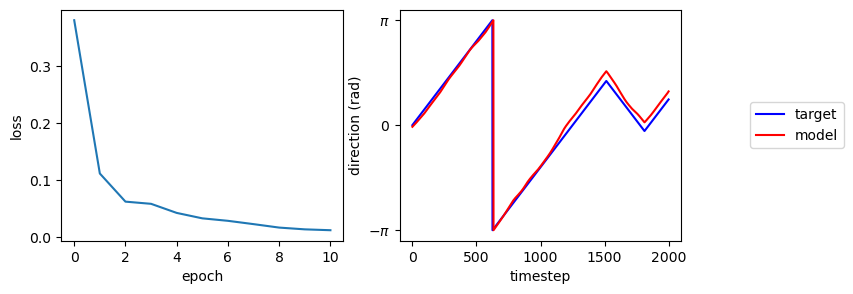

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
targets_to_plot = targets[0, :, :]
x = torch.Tensor(inputs[0, :, :]).unsqueeze(1)

# forward pass
outputs, acts = net(x)
output_arr = outputs.detach().cpu().numpy()

ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss') # set y label

ax[1].plot(range(targets.shape[1]), np.arctan2(targets[0, :, 1], targets[0, :, 0]), label='target', color='blue')
ax[1].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 1], output_arr.squeeze(1)[:, 0]), label='model', color='red')
ax[1].set_xlabel('timestep') # set x label
ax[1].set_ylabel('direction (rad)') # set y label
ax[1].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

In [18]:
acts.shape

torch.Size([2000, 1, 200])

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import clear_output

# Define your plot function
def update(i):
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))  # Optional: Set a figure size
    plt.plot(acts[i, 0, :].T.detach().cpu().numpy(), 'b-', marker='o')
    plt.xlim(0, len(acts[i, 0, :]))  # Set the x-limits (optional)
    plt.xlabel('Time')
    plt.title(f'Hidden activity at time {i}')

    # show the plot again after updating
    plt.show()

widget = interactive(update, i=(0, len(acts[:, ...])-1, 10))
display(widget)


interactive(children=(IntSlider(value=990, description='i', max=1999, step=10), Output()), _dom_classes=('widg…

Some parameter notes: 
- task: 
    - dt = 0.01 
    - num_timesteps = 2000
    - omega_value = 0.5 

- network:
    - num_neurons = 100
    - dt = 0.5 

In general, how do we want to choose the task/network timescales to make them more realistic / make sense? 

# Integrating two independent velocities

In [72]:
from src.multimodular_rnn import MultiModRNN, RingModule

In [120]:
# training data generation
from tasks.independent_integration_task import generate_dataset

num_samples = 1
num_trajectories = 2
num_timesteps = 2000
num_flips = 5
# omega_process = 'constant'
omega_process = 'binary'
omega_value = 0.5
dt = .01

# Generate the dataset
inputs, targets = generate_dataset(num_samples,
                                   num_timesteps,
                                   num_trajectories,
                                   trajectory_type=omega_process,
                                   dt=dt,
                                   num_flips=num_flips,
                                   omega_value=omega_value,
                                   include_initial_position=False
                                   )

In [74]:
print(inputs.shape)
print(targets.shape)

(1, 2000, 2)
(1, 2000, 4)


In [128]:
# initialize the network 

torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

input_size = inputs.shape[2]
output_size = targets.shape[2]
nNeurons=100


net = MultiModRNN(input_size,
             output_size,
             n_modules=2,
             device=device,
             nNeurons=nNeurons,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 12
            )



device = cpu


In [129]:
criterion = torch.nn.MSELoss()
learning_rate = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 200
clip_value = 2 # Define the gradient clip value

losses = []
perfs = []
hidden_activity = torch.zeros((num_epochs, num_samples, num_timesteps, 2*nNeurons)) # store hidden activity

# input_weights = torch.zeros((num_epochs, num_samples, num_timesteps, )) 


# store output weight norms 
output_weight_norms_1 = torch.zeros((num_epochs))
output_weight_norms_2 = torch.zeros((num_epochs))



for epoch in range(num_epochs):
    running_loss = 0.0
    indices = torch.randperm(num_samples)

    for i in range(num_samples):

        idx = indices[i]
        x = torch.Tensor(inputs[idx]).unsqueeze(1).to(device)
        y = torch.Tensor(targets[idx]).unsqueeze(1).to(device)

        outputs, activity = net(x)
        # hidden_activity[epoch, i, :] = activity.squeeze(1).detach().cpu()[:, :]
        
        # outputs = torch.Tensor(outputs).unsqueeze(1)
        outputs = torch.Tensor(outputs)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping step after backpropagation and before optimization step
        torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)
        
        optimizer.step()
        running_loss += loss.item()

    output_weight_norm_1 = net.output.weight.data[:2,:200].norm() 
    output_weight_norm_2 = net.output.weight.data[2:,:200].norm()
    output_weight_norms_1[epoch] = output_weight_norm_1
    output_weight_norms_2[epoch] = output_weight_norm_2



    avg_loss = running_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')

    if running_loss/num_samples < 0.001:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break

Epoch 1/200
Average train loss: 0.47166377845146650882
Epoch 2/200
Average train loss: 0.29966431538703180992
Epoch 3/200
Average train loss: 0.21872646642891088731
Epoch 4/200
Average train loss: 0.19985720984581081816
Epoch 5/200
Average train loss: 0.20997150449696680430
Epoch 6/200
Average train loss: 0.21915342563273174092
Epoch 7/200
Average train loss: 0.21657380191846750672
Epoch 8/200
Average train loss: 0.20482617303514105700
Epoch 9/200
Average train loss: 0.18889845048734740796
Epoch 10/200
Average train loss: 0.17315098325500152820
Epoch 11/200
Average train loss: 0.16131835639619793166
Epoch 12/200
Average train loss: 0.15431984358714712080
Epoch 13/200
Average train loss: 0.15038944665120407285
Epoch 14/200
Average train loss: 0.14613662137663416263
Epoch 15/200
Average train loss: 0.13980140648669647785
Epoch 16/200
Average train loss: 0.13146992245586688886
Epoch 17/200
Average train loss: 0.12209101743357257674
Epoch 18/200
Average train loss: 0.11352497824903678980
E

KeyboardInterrupt: 

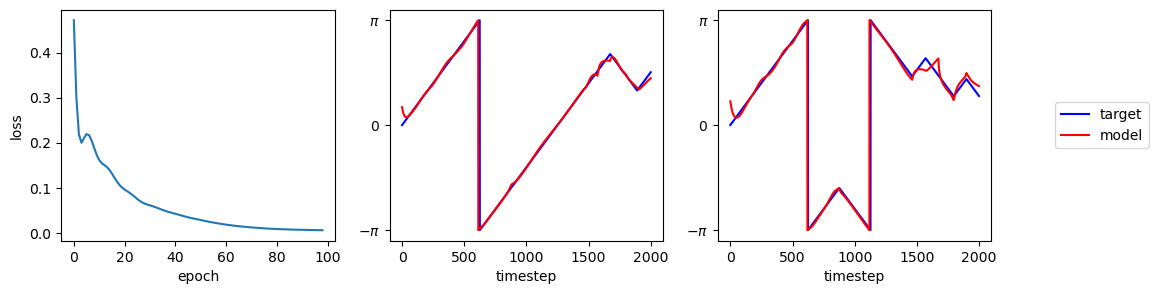

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
targets_to_plot = targets[0, :, :]
x = torch.Tensor(inputs[0, :, :]).unsqueeze(1)

# forward pass
outputs, _ = net(x)
output_arr = outputs.detach().cpu().numpy()

ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss') # set y label

ax[1].plot(range(targets.shape[1]), np.arctan2(targets[0, :, 1], targets[0, :, 0]), label='target', color='blue')
ax[1].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 1], output_arr.squeeze(1)[:, 0]), label='model', color='red')
ax[1].set_xlabel('timestep') # set x label
# ax[1].set_ylabel('direction (rad)') # set y label
ax[1].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])

ax[2].plot(range(targets.shape[1]), np.arctan2(targets[0, :, 3], targets[0, :, 2]), label='target', color='blue')
ax[2].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 3], output_arr.squeeze(1)[:, 2]), label='model', color='red')
ax[2].set_xlabel('timestep') # set x label
# ax[2].set_ylabel('direction (rad)') # set y label
ax[2].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
ax[2].legend(loc='center right', bbox_to_anchor=(1.6, 0.5))

plt.show()

In [131]:
output_weight_norms_1.shape

torch.Size([200])

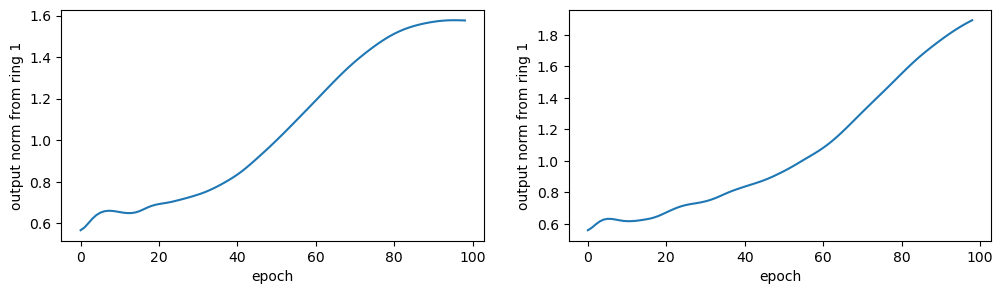

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(output_weight_norms_1[:epoch])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('output norm from ring 1') 

ax[1].plot(output_weight_norms_2[:epoch])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('output norm from ring 1') 

plt.show()

# Integrating multiple independent velocities

In [28]:
# training data generation
from tasks.independent_integration_task import generate_dataset
from src.multimodular_rnn import MultiModRNN, RingModule

num_samples = 1
num_trajectories = 5
num_timesteps = 2000
num_flips = 8
# omega_process = 'constant'
omega_process = 'binary'
omega_value = 0.5
dt = .01

# Generate the dataset
inputs, targets = generate_dataset(num_samples,
                                   num_timesteps,
                                   num_trajectories,
                                   trajectory_type=omega_process,
                                   dt=dt,
                                   num_flips=num_flips,
                                   omega_value=omega_value,
                                   include_initial_position=False
                                   )

# initialize the network 

torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

input_size = inputs.shape[2]
output_size = targets.shape[2]
nNeurons=100


net = MultiModRNN(input_size,
             output_size,
             n_modules=  num_trajectories,
             device=device,
             nNeurons=nNeurons,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 12
            )

criterion = torch.nn.MSELoss()
learning_rate = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 200
clip_value = 2 # Define the gradient clip value

losses = []
perfs = []
hidden_activity = torch.zeros((num_epochs, num_samples, num_timesteps, 2*nNeurons)) # store hidden activity

for epoch in range(num_epochs):
    running_loss = 0.0
    indices = torch.randperm(num_samples)

    for i in range(num_samples):

        idx = indices[i]
        x = torch.Tensor(inputs[idx]).unsqueeze(1).to(device)
        y = torch.Tensor(targets[idx]).unsqueeze(1).to(device)

        outputs, activity = net(x)
        # hidden_activity[epoch, i, :] = activity.squeeze(1).detach().cpu()[:, :]
        
        # outputs = torch.Tensor(outputs).unsqueeze(1)
        outputs = torch.Tensor(outputs)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping step after backpropagation and before optimization step
        torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)
        
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')

    if running_loss/num_samples < 0.001:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break


device = cpu
Epoch 1/200
Average train loss: 0.52946117553193738914
Epoch 2/200
Average train loss: 0.31549435703177008961
Epoch 3/200
Average train loss: 0.28563998626758319022
Epoch 4/200
Average train loss: 0.25925178001237098036
Epoch 5/200
Average train loss: 0.25222397125530593431
Epoch 6/200
Average train loss: 0.23176162067415026491
Epoch 7/200
Average train loss: 0.19693235878842332842
Epoch 8/200
Average train loss: 0.17198887716286156979
Epoch 9/200
Average train loss: 0.16990916427663868560
Epoch 10/200
Average train loss: 0.17653195680448938165
Epoch 11/200
Average train loss: 0.17323682223533112823
Epoch 12/200
Average train loss: 0.15832959582063491077
Epoch 13/200
Average train loss: 0.14321167141439758441
Epoch 14/200
Average train loss: 0.13626889125584021323
Epoch 15/200
Average train loss: 0.13639272267253785276
Epoch 16/200
Average train loss: 0.13698871355719582921
Epoch 17/200
Average train loss: 0.13351949411613578400
Epoch 18/200
Average train loss: 0.127133593

KeyboardInterrupt: 

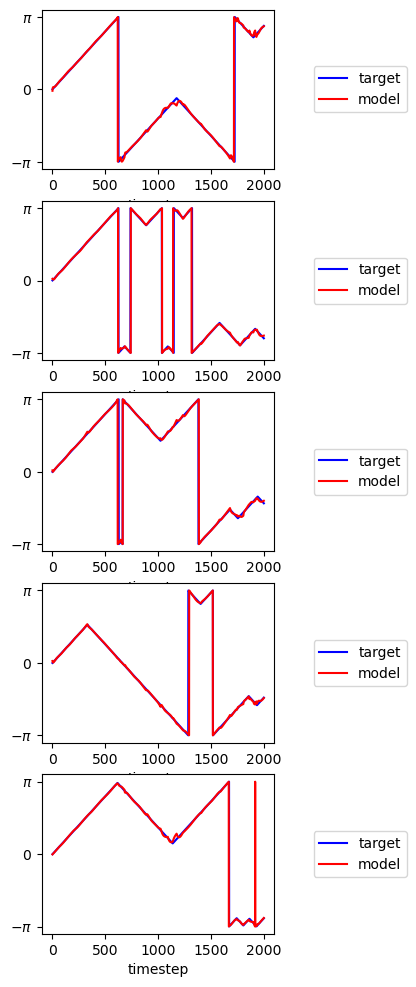

In [30]:
fig, ax = plt.subplots(num_trajectories, 1, figsize=(3, 12))
targets_to_plot = targets[0, :, :]
x = torch.Tensor(inputs[0, :, :]).unsqueeze(1)

# forward pass
outputs, _ = net(x)
output_arr = outputs.detach().cpu().numpy()


for i in range(num_trajectories):
    ax[i].plot(range(targets.shape[1]), np.arctan2(targets[0, :, 2*i+1], targets[0, :, 2*i]), label='target', color='blue')
    ax[i].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 2*i+1], output_arr.squeeze(1)[:, 2*i]), label='model', color='red')
    ax[i].set_xlabel('timestep') # set x label
    ax[i].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
    ax[i].legend(loc='center right', bbox_to_anchor=(1.6, 0.5))

plt.show()